In [64]:
import csv
import cv2
import os
import random
import numpy as np
import sklearn
from sklearn.cross_validation import train_test_split

# get data from csv file
samples = []
with open('./udacity_data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

# takes out the first line which are just labels
samples.pop(0)

# split training and validation data
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

angle_adjustments = 0.375

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # loops forever so the generator never terminates
        random.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles = []
            
            for batch_sample in batch_samples:
                for i in range(3):
                    name = './udacity_data/IMG/'+batch_sample[i].split('/')[-1]
                    image = cv2.imread(name)
                    images.append(image)
                    if i == 0:
                        angle = float(batch_sample[3])
                        angles.append(angle)
                    if i == 1:
                        angle = float(batch_sample[3]) + angle_adjustments
                        angles.append(angle)
                    if i == 2:
                        angle = float(batch_sample[3]) - angle_adjustments
                        angles.append(angle)

            
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)


# compile and train model using the generator function
train_generator = generator(train_samples, batch_size=64)
validation_generator = generator(validation_samples, batch_size=64)

In [65]:
from keras.models import Sequential
from keras.layers import Flatten,Dense, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D

model = Sequential()

model.add(Cropping2D(cropping=((70,25),(1,1)), input_shape=(160,320,3)))
model.add(Convolution2D(24,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer = 'adam')
history_object = model.fit_generator(
    train_generator,
    samples_per_epoch=len(train_samples), 
    validation_data=validation_generator,
    nb_val_samples=len(validation_samples),
    nb_epoch=3)

model.save('model.h5')

Epoch 1/3
6528/6428 [==============================] - 8s - loss: 0.2144 - val_loss: 0.0607
Epoch 2/3
6528/6428 [==============================] - 7s - loss: 0.0590 - val_loss: 0.0567
Epoch 3/3
6612/6428 [==============================] - 7s - loss: 0.0523 - val_loss: 0.0550


['loss', 'val_loss']


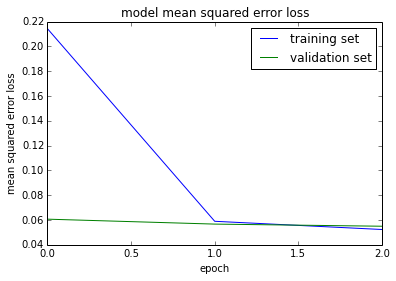

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
